In [19]:
from torch.nn.modules.flatten import Flatten
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

image_size = 28
lr = 0.001


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)


# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder_conv = nn.Sequential(

            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ELU(),

            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ELU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ELU(),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ELU(),

            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ELU()
        )
        self.decoder_conv = nn.Sequential(

         nn.ConvTranspose2d(in_channels=16, out_channels=128, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(128),
         nn.ELU(),

         nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(64),
         nn.ELU(),

         nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(32),
         nn.ELU(),

         nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(8),
         nn.ELU(),

         nn.Upsample(scale_factor=2, mode='nearest'),  # Upsample
         nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(1),
         nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder_conv(x)
        x = self.decoder_conv(x)
        return x

# Initialize the model, loss function, and optimizer
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr = lr)

# Training loop
epochs = 3

for epoch in range(epochs):
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)
        #print(inputs.size())
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        #print(outputs.size())
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [1/3], Loss: 1.3614
Epoch [2/3], Loss: 1.1792
Epoch [3/3], Loss: 1.0834


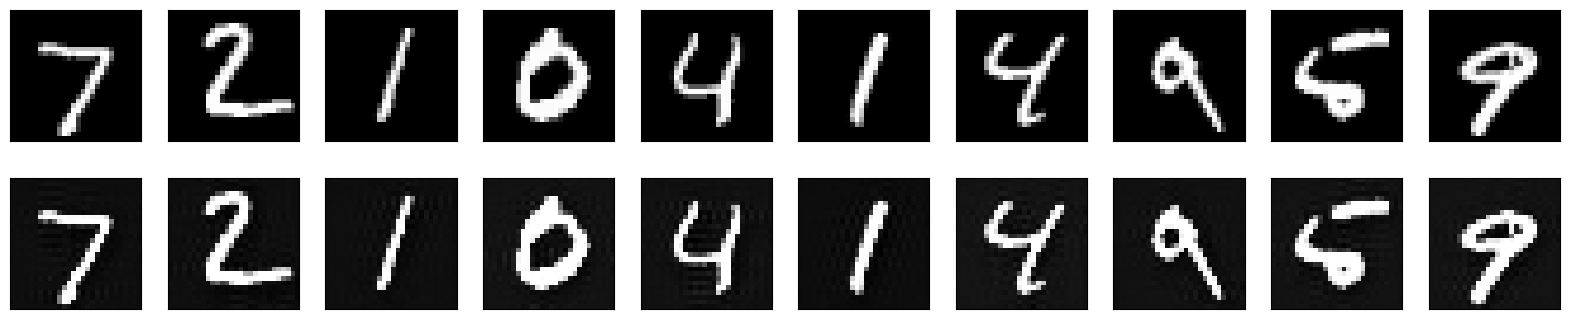

In [20]:

# Test the Autoencoder
with torch.no_grad():
    for data in test_loader:
        inputs, _ = data
        inputs = inputs.to(device)

        outputs = autoencoder(inputs)

        # Display original and reconstructed images
        n = 10  # Number of digits to display
        plt.figure(figsize=(20, 4))
        for i in range(n):
            # Original Images
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(inputs[i].cpu().view(28, 28).numpy(), cmap='gray')
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # Reconstructed Images
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(outputs[i].cpu().view(28, 28).numpy(), cmap='gray')
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.show()
        break  # Only display one batch of test data
